In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# Support vector classifier: scikit learn has all kinds of good stuff for this...
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score

# also define the default font we'll use for figures. 
fig_font = {'fontname':'Arial', 'size':'20'}

In [7]:
## change cwd
%cd "/Users/t.z.cheng/Google_Drive/Coursework/PSYC231/python2020/w6"

/Users/t.z.cheng/Google_Drive/Coursework/PSYC231/python2020/w6


In [8]:
# load the data...
eeg = np.load('class_demo_eeg.npz')

# get the different arrays like this...
eeg['data']
eeg['sr']
eeg['tx']
eeg['cond_labels']

# shape of data
print('Shape of the big eeg data set: ', eeg['data'].shape)

# and if you want to save some typing, especially because we only have a few variables, you reassign the different arrays like this
data = eeg['data']
sr = eeg['sr']
tx = eeg['tx']
cond_labels = eeg['cond_labels']

Shape of the big eeg data set:  (960, 20, 250)


## Compute the mean across the first dimension (trials) and then plot the mean response across time in each of the 20 electrodes on one axis
- May need to transpose the data...
- Put labels on the axes, and plot a horizontal line at the 0 mV point.

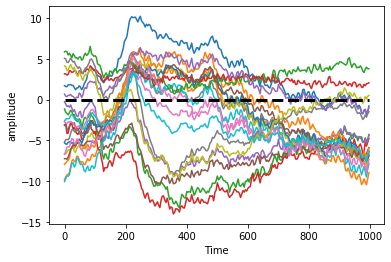

In [10]:
mean_time = np.mean(data, axis = 0)
plt.plot(tx,mean_time.T)
plt.xlabel('Time')
plt.ylabel('amplitude')
plt.plot(tx,np.zeros(len(tx)),'k--',linewidth = 3)

plt.show()

## That gives you an idea about what the pattern of data looks like across electrodes.
- Next, take the mean across time separately in each electrode, so you should end up with a 960 x 20 matrix
- Use the cond_labels vector to sort the data based on condition (so you have two 480 x 20 matrices), one matrix for each experimental condition.
- Take 90% (or thereabouts) of the data from each condition and use that as a training set. Use the remaining 10% of data from each condition as a test set.
- Do classification to see if you can decode the experimental condition - train the model on your "training" data, and then test on the held out 10% from each condition.

In [11]:
mean_ac_time = np.mean(data, axis = 2)
r,c = np.shape(mean_ac_time)

In [12]:
trial_0 = []
trial_1 = []
label_0 = []
label_1 = []
for i in np.arange(r):
    if cond_labels[i] == 0:
        trial_0.append(mean_ac_time[i])
        label_0.append(cond_labels[i])
    else: 
        trial_1.append(mean_ac_time[i])
        label_1.append(cond_labels[i])

In [13]:
p_train = 0.9
n_train = int(round(len(trial_0)*p_train,0))
data_train = np.vstack((trial_0[:n_train], trial_1[:n_train])) # need two ()
data_test = np.vstack((trial_0[n_train:], trial_1[n_train:]))
labels_train = np.hstack((label_0[:n_train], label_1[:n_train]))
labels_test = np.hstack((label_0[n_train:], label_1[n_train:]))

In [14]:
np.shape(data_train)

(864, 20)

In [15]:
model = SVC(kernel = 'linear', C = 1)
model.fit(data_train,labels_train)
predict = model.predict(data_test)

In [17]:
correct = predict == labels_test

In [19]:
print(sum(correct)/len(correct))

0.5520833333333334


## Now try doing this across timepoints!
- First do a time window based on where you think there is nice separation in the responses across electrodes (look at the data that you plotted above)...maybe try 300-400msec post stim and a few others...
- Bonus on your own: try timepoint x timepoint or a moving window (e.g. a series of 10ms bins)

In [20]:
# just for a demo, pick out a temporal window over which to average
t_win = (tx>=300) & (tx<400)

In [21]:
# mean of 3rd dim (time)
mean_ac_time = np.mean(data[:,:,t_win], axis=2)

In [22]:
# sort data into two conditions
data0 = mean_ac_time[cond_labels==0,:]
data1 = mean_ac_time[cond_labels==1,:]

In [23]:
# define how much training data to use
pcnt_trn = .9
num_train_per_cond = int(np.floor(pcnt_trn * data0.shape[0]))

# then separate out training and test data
trn_data = np.vstack( (data0[:num_train_per_cond,:], data1[:num_train_per_cond,:])  )
trn_labels = np.hstack((np.zeros(num_train_per_cond), np.ones(num_train_per_cond)))

# then assign the test set and test set labels
tst_data = np.vstack( (data0[num_train_per_cond:,:], data1[num_train_per_cond:,:])  )
num_tst_per_cond = int(tst_data.shape[0]/2)
tst_labels = np.hstack((np.zeros(num_tst_per_cond), np.ones(num_tst_per_cond)))

# SVC 
model = SVC(kernel='linear', C=1)

# then fit the model to our training data by passing in the data matrix + a list of labels that denotes the 
# experimental condition for each trial
model.fit(trn_data, trn_labels)

# then predict
class_labels = model.predict(tst_data)

# Then just compute our classification accuracy by comparing the predicted labels to the ground truth
class_acc = np.sum(class_labels==tst_labels) /  tst_data.shape[0]
print('Classification accuracy with a SVM is: ', class_acc)

Classification accuracy with a SVM is:  0.6770833333333334
